# Load libraries

In [1]:
# import [package name] as [name abbr.]
# python 處理數字跟 tensor 運算的主要套件
import numpy as np
# google 的 NN coding 套件
import tensorflow as tf

# 有可能會出現警告，但是可以不用理他
# c:\users\silver\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36:
# FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating`
# is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
# from ._conv import register_converters as _register_converters

import matplotlib.pyplot as plt

# Load Dataset

In [2]:
exec(open("00_readingInput.py").read())
feature_dim = X_train.shape[1]
classes = 5

Training data (1652, 200)
Training label (1652,)
Testing data (184, 200)
Testing label (184,)


In [3]:
# Define Model Input (x) and Output (y_),  y_ = f(x)
x = tf.placeholder(tf.float32, [None, X_train.shape[1]])
y_ = tf.placeholder(tf.int32, [None])
y_one = tf.one_hot(y_,classes)

Ex 07
監視 validation loss，讓其能容忍不思長進三次
Hint:
if(valid_loss < min_loss):
    min_loss = valid_loss
    stop_tol = 0
else:
    if(stop_tol == 3):
        break
    else:
        stop_tol = stop_tol + 1

In [4]:
reg_h1 = tf.layers.dense(x,128,activation=None,
                         kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.01))
reg_h1_act = tf.nn.relu(reg_h1)
reg_h2 = tf.layers.dense(reg_h1_act,256,activation=None,
                         kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.01))
reg_h2_act = tf.nn.relu(reg_h2)
reg_y = tf.layers.dense(reg_h2_act,classes,activation=None)

reg_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_one, logits=reg_y))
l2_loss = tf.losses.get_regularization_loss()
tot_loss = reg_loss+l2_loss

reg_train_step = tf.train.AdamOptimizer(0.001).minimize(tot_loss)

# Accuracy of the Model
reg_y_pred = tf.argmax(tf.nn.softmax(reg_y), 1, output_type=tf.int32)
reg_correct = tf.equal(reg_y_pred, y_)
reg_accuracy = tf.reduce_mean(tf.cast(reg_correct, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [5]:
# initialize the models
sess = tf.InteractiveSession(
    config=tf.ConfigProto(
    device_count={'CPU' : 1, 'GPU' : 0},
    allow_soft_placement=True,
    log_device_placement=False
    ))
tf.global_variables_initializer().run()

# Training & Evaluation

In [6]:
epoch = 50
batch_size = 16
get_batches = gen_batches(X_train, Y_train, batch_size)
batches_in_a_epoch = int(X_train.shape[0]/batch_size)

In [7]:
reg_hist_train_acc = []
reg_hist_valid_acc = []
reg_hist_train_loss = []
reg_hist_valid_loss = []

min_loss = 999999999
stop_tol = 0
for step in range(epoch*batches_in_a_epoch):
    batch_xs, batch_ys = next(get_batches)
    sess.run(reg_train_step, feed_dict={x: batch_xs, y_: batch_ys})
    if (step % batches_in_a_epoch == 0):
        # trainin and validation evaluation
        train_loss, train_acc = sess.run([reg_loss,reg_accuracy], feed_dict={x: X_train, y_: Y_train})
        valid_loss, valid_acc = sess.run([reg_loss,reg_accuracy], feed_dict={x: X_test,  y_: Y_test})
        reg_hist_train_acc.append(train_acc)
        reg_hist_valid_acc.append(valid_acc)
        reg_hist_train_loss.append(train_loss)
        reg_hist_valid_loss.append(valid_loss)
        #print("Accuracy: [T] %.4f / [V] %.4f" % (train_acc,valid_acc))
        if(valid_loss < min_loss):
            min_loss = valid_loss
            stop_tol = 0
        else:
            if(stop_tol == 3):
                break
            else:
                stop_tol = stop_tol + 1

sess.close()

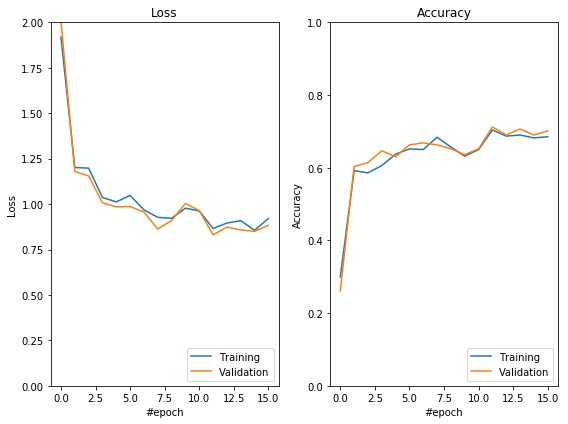

In [8]:
plt.figure(0,figsize=(8,6))
plt.subplot(121)
x = [x for x in range(len(reg_hist_train_loss))]
line_train, = plt.plot(x, reg_hist_train_loss, label='Training')
line_valid, = plt.plot(x, reg_hist_valid_loss, label='Validation')
plt.xlabel('#epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.ylim([0,2])
plt.legend(handles=[line_train,line_valid], loc=4)
plt.subplot(122)
x = [x for x in range(len(reg_hist_train_acc))]
line_train, = plt.plot(x, reg_hist_train_acc, label='Training')
line_valid, = plt.plot(x, reg_hist_valid_acc, label='Validation')
plt.xlabel('#epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.ylim([0,1])
plt.legend(handles=[line_train,line_valid], loc=4)
plt.tight_layout()
plt.savefig('./training_curve/ex07_Earlystop.png',dpi=300,format='png')
plt.show()
plt.close()